#### Get multiple threads going

In [17]:
import os
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['GOTO_NUM_THREADS'] = '8'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['openmp'] = 'True'

#### Import some libraries

In [56]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras import Input
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

#### Define some short helper functions

In [19]:
# Returns an one-hot encoded array of integer 0-9
# 3 -> [0,0,0,1,0,0,0,0,0,0]
def onehot(ARRAY):
    return np.eye(10)[ARRAY].astype(np.uint8)

# Reshapes the data from the MNIST csv
# Returns a 2D representation (28x28)px of the raw MNIST data
def squareup(ARRAY):
    return ARRAY.reshape(28,28)

#### Load the data

In [21]:
# Try to load processed data first
try:
    with open('./input/inputs.npy',"rb") as f:
        inputs = np.load(f)
    with open('./input/outputs.npy',"rb") as f:
        outputs = np.load(f)
        
# Load data an process if not available      
except:
    data = np.genfromtxt('./input/train.csv', delimiter=',',skip_header=1,dtype=np.uint8)
    temp_inputs = data[:,1:]
    inputs = np.zeros((temp_inputs.shape[0],28,28,1))
    # Convert linear data from MNIST to 2D image
    for i in range(len(temp_inputs)):
        inputs[i,:28,:28,0] = squareup(temp_inputs[i])
    outputs = data[:,0]
    del temp_inputs, data
    # Save for faster loading next time
    np.save('./input/inputs.npy',inputs)
    np.save('./input/outputs.npy',outputs)
print(f'Input:\nShape:{inputs.shape}\n{inputs[0,:5,:5,0]}\n')
print(f'Output:\nShape:{outputs.shape}\n{outputs[:5]}\n')

Input:
Shape:(42000, 28, 28, 1)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Output:
Shape:(42000,)
[1 0 1 4 0]



#### View some MNIST handwritten digits

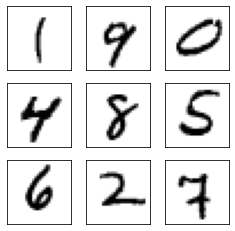

In [89]:
fig = plt.figure(figsize=(4,4))
for i in range(1,10):
    plt.subplot(f'33{i}')
    plt.tick_params(left=False,
                    labelleft=False,
                    bottom=False,
                    labelbottom=False
                   )
    plt.imshow(inputs[i*(np.round(np.random.random()*100)).astype(int),:29,:29,0], cmap='gray_r')
plt.show()

#### Prepare the data to be modeled

In [24]:
inputs = inputs/255.0 #Normalize
X_train, X_test, y_train, y_test = train_test_split(inputs,outputs,test_size = 0.2)


y_train_hot = onehot(y_train)
y_test_hot = onehot(y_test)

print(X_train.shape)
print(y_train_hot.shape)

(33600, 28, 28, 1)
(33600, 10)


#### Assemble a convolutional neural network

In [71]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(data_format=None))
model.add(Dense(units=64))
model.add(Dense(units=10))
model.add(Activation("softmax"))

In [72]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [73]:
model.fit(X_train, y_train_hot, 
          epochs=4, 
          batch_size=336,
         )
model.summary()

Epoch 1/6
33600/33600 [==============================] - 385s 11ms/step - loss: 0.4279 - acc: 0.8666
Epoch 2/6
33600/33600 [==============================] - 386s 11ms/step - loss: 0.0944 - acc: 0.9700
Epoch 3/6
33600/33600 [==============================] - 383s 11ms/step - loss: 0.0608 - acc: 0.9816
Epoch 4/6
33600/33600 [==============================] - 392s 12ms/step - loss: 0.0461 - acc: 0.9850
Epoch 5/6
33600/33600 [==============================] - 394s 12ms/step - loss: 0.0353 - acc: 0.9889
Epoch 6/6
33600/33600 [==============================] - 378s 11ms/step - loss: 0.0285 - acc: 0.9909
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
________________________________________________________________

In [75]:
model.evaluate(X_test, y_test_hot, batch_size=840)

8400/8400 [==============================] - 31s 4ms/step


[0.03913174904882908, 0.9875]

In [76]:
out = model.predict(X_test)

[0 0 0 0 1 0 0 0 0 0]


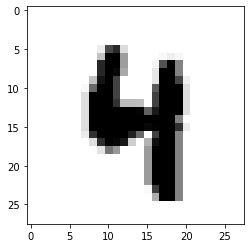

In [111]:
K = 24
print(np.round(out[K]).astype(int))
plt.imshow(X_test[K,:29,:29,0],cmap='gray_r')

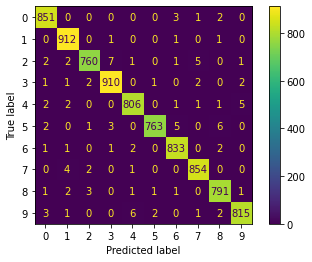

In [102]:
c_mat = confusion_matrix(y_test_hot.argmax(axis=1),out.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix = c_mat,display_labels=list(range(0,10)))
disp.plot(values_format='d')